### Gathering Insights from airbnb city data for Seattle using Data science and Machine Learning



#### Get the required packages

In [1]:
# The anaconda environment used here comes with python 3.6 and all the necessary packages installed except for basemap which
# needs to be installed and scikit-learn which needs to be updated to v0.21

import os

#import functions module
from functions import *

#Data retrival and handling packages
import pandas as pd
import pandas_profiling
import numpy as np

#Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm

#Get scikit learn tools for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style='ticks')

#### Fetch airbnb city data from the local repository


In [2]:
#get calendar and listings data
calendar = get_airbnb_data('seattle', 'calendar')
listings = get_airbnb_data('seattle', 'listings')

calendar.sample(5)

,listing_id,date,available,price
53556,7603135,2016-09-26,t,$225.00
1158588,5261239,2016-03-22,t,$114.00
653850,1000883,2016-05-18,t,$100.00
853743,8409969,2016-01-12,f,NaN
373300,7619060,2016-09-30,f,NaN


In [3]:
listings.sample(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
2717,745099,https://www.airbnb.com/rooms/745099,20160104002432,2016-01-04,Beautiful & Central in High End St.,NaN,We have a nice bedroom divided in two differen...,We have a nice bedroom divided in two differen...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
2107,5056580,https://www.airbnb.com/rooms/5056580,20160104002432,2016-01-04,Soaring Crane Luxury Garden Retreat,Gorgeous professionally-designed 850 square fo...,Welcome to my professionally designed luxury 8...,Gorgeous professionally-designed 850 square fo...,none,"North Beacon Hill is a very diverse, welcoming...",...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,10.95
1235,5900224,https://www.airbnb.com/rooms/5900224,20160104002432,2016-01-04,Walk to the best spots in Seattle,Walk to the best spots Seattle has to offer fr...,This studio apartment is hip and comfortable f...,Walk to the best spots Seattle has to offer fr...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,1,1.46
1864,153967,https://www.airbnb.com/rooms/153967,20160104002432,2016-01-04,Cottage in West Seattle $117/night,$117 per night ($138 per night June - August)....,$117 per night ($138 per night June - August) ...,$117 per night ($138 per night June - August)....,none,NaN,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,2,0.98
88,3584790,https://www.airbnb.com/rooms/3584790,20160104002432,2016-01-04,2 Bedrm Apt in the heart of Ballard,Bright clean 2 bedroom 1 bath appartment in th...,"Cozy and a little ecclectic, brings out the re...",Bright clean 2 bedroom 1 bath appartment in th...,none,Ballard is the most interesting and ecclectic ...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN


#### Format Calendar data 



In [4]:
#Convert date to pandas datetime format
calendar['date'] = to_date_time(calendar.date)

#Convert price to type float
calendar['price'] = to_numeric(calendar.price)

calendar.sample(5)

,listing_id,date,available,price
413458,4481979,2016-10-08,t,139.0
221462,9258305,2016-10-02,f,NaN
281189,7649837,2016-05-22,f,NaN
1338412,1796302,2016-11-21,f,NaN
231118,8848854,2016-03-17,f,NaN


#### Visualize pricing trends in relation to time of year

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


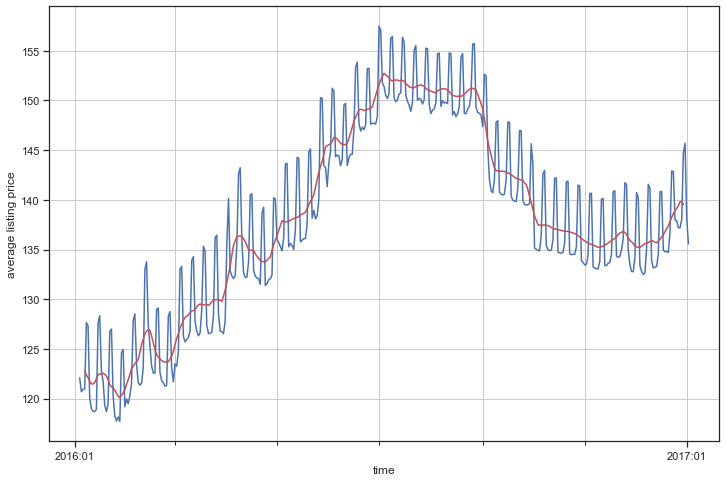

In [5]:
#for each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

#decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    #price = Level + Trend + Seasonality + Noise

#plot oberved time series of property prices
plot_time_series(df.index, df.price)

#plot price trend
plt.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

#### Clean and format listings data

In [6]:
#Look at the features
pandas_profiling.ProfileReport(listings)

Number of variables,92
Number of observations,3818
Total Missing (%),8.5%
Total size in memory,2.7 MiB
Average record size in memory,736.0 B
Numeric,25
Categorical,51
Boolean,0
Date,0
Text (Unique),2
Rejected,14


In [7]:
# Ignore features with (1) high cardinality, (2) constant value, (3) high skewness, (4) lot of missing data and
# (5) very high corelation with another feature
# also ignore features with no relation to price whatsoever (listing id, calendar last scraped etc)

num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds', 'price','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy']

listings = listings[num_cols+cat_cols]

#get pricing data from the calendar dataset
listings['price'] = calendar.groupby('listing_id', sort=False, as_index=False)['price'].mean().drop('listing_id', axis=1)

listings.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,reviews_per_month,availability_365,guests_included,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable,cancellation_policy
0,47.636289,-122.371025,4,1.0,1.0,1.0,85.000000,207,4.07,346,2,within a few hours,f,t,Queen Anne,Apartment,Entire home/apt,f,moderate
1,47.639123,-122.365666,4,1.0,1.0,1.0,170.931271,43,1.48,291,1,within an hour,t,t,Queen Anne,Apartment,Entire home/apt,f,strict
2,47.629724,-122.369483,11,4.5,5.0,7.0,1301.818182,20,1.15,220,10,within a few hours,f,t,Queen Anne,House,Entire home/apt,f,strict
3,47.638473,-122.369279,3,1.0,0.0,2.0,100.000000,0,NaN,143,1,NaN,f,t,Queen Anne,Apartment,Entire home/apt,f,flexible
4,47.632918,-122.372471,6,2.0,3.0,3.0,462.739726,38,0.89,365,6,within an hour,f,t,Queen Anne,House,Entire home/apt,f,strict


In [8]:
#copy listings for analysis
df = listings.copy()

all_cols = num_cols+cat_cols

#numeric to object conversion
for col in num_cols:
    df[col] = pd.qcut(df[col], 10, duplicates='drop')
    df[col] = df[col].astype(str).values

#object to category conversion for faster
for col in cat_cols:
    df[col] = df[col].astype('category')

phi_scores_all = np.empty((19,19))
for i in range(len(all_cols)):
    for j in range(len(all_cols)):
        if i==j:
            phi_scores_all[i,j]=1.0
        else:
            conf_matrix = pd.crosstab(df[all_cols[i]], df[all_cols[j]])
            phi_scores_all[i,j] = get_phi_score(conf_matrix)

corr = pd.DataFrame(phi_scores_all, columns=all_cols, index=all_cols)

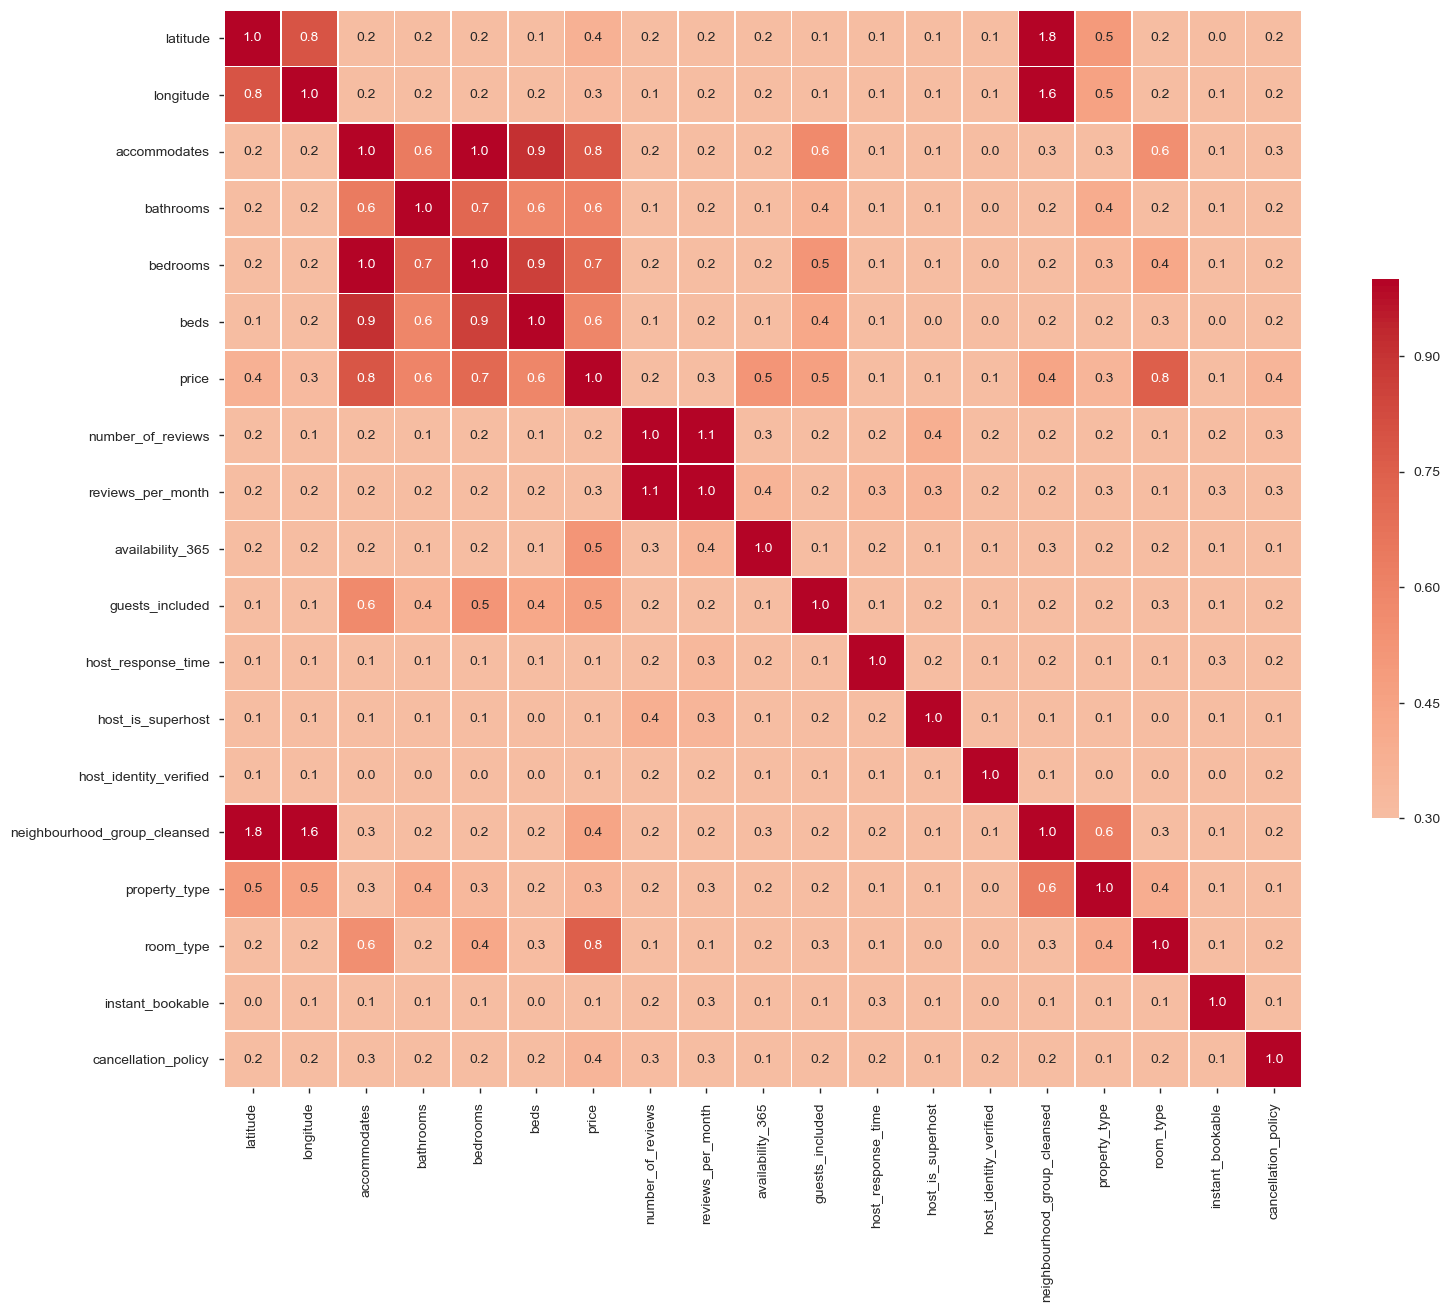

In [9]:
g = sns.heatmap(corr, vmin=0.3, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(18,14)

plt.show()

#### Visualize feature correlations

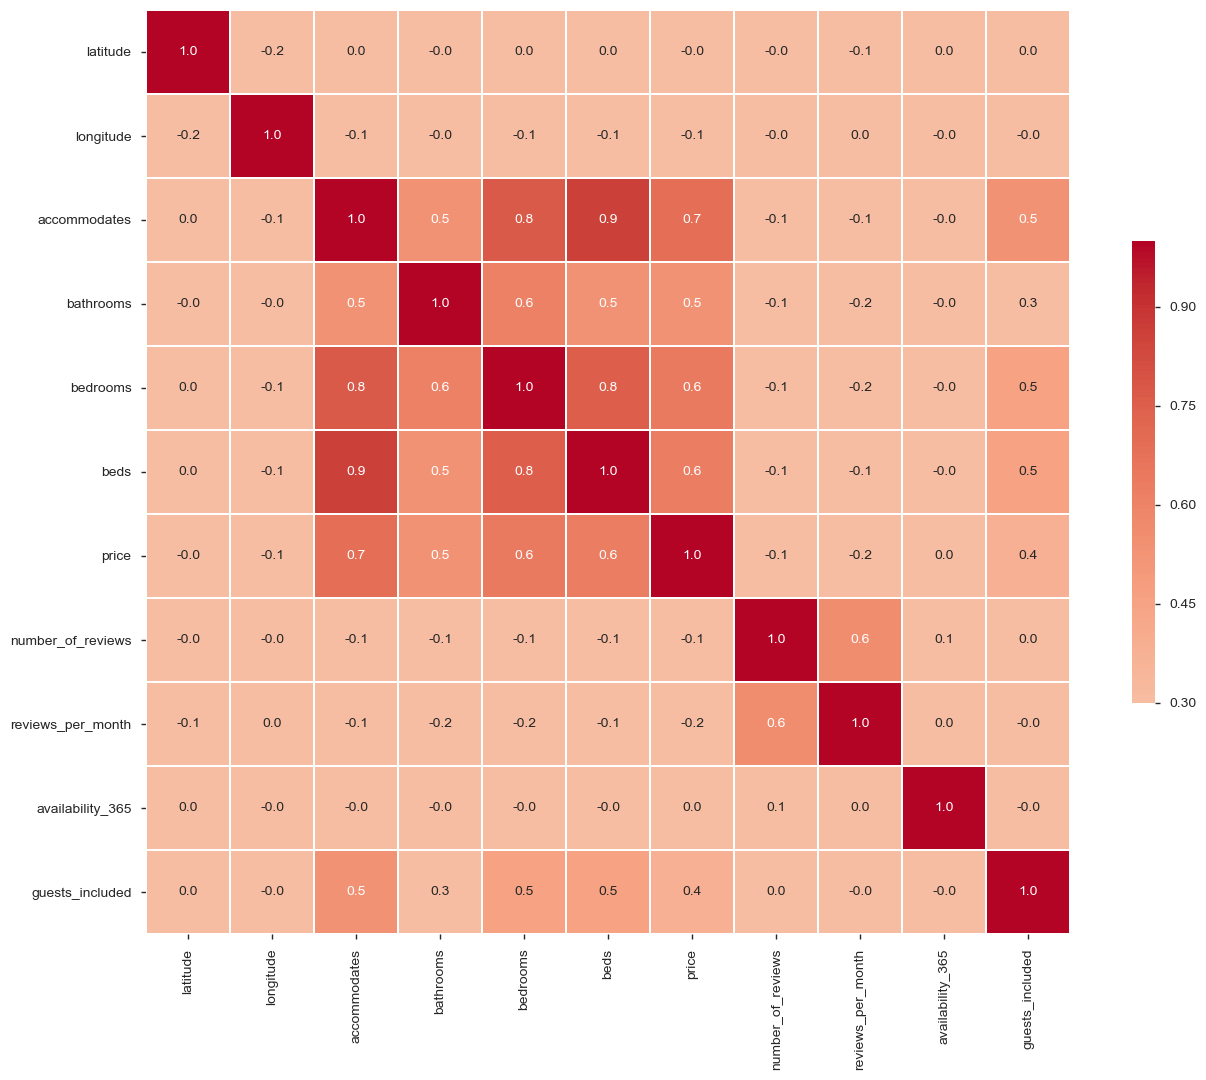

In [17]:
corr = listings.corr()
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(16,12)

plt.show()

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


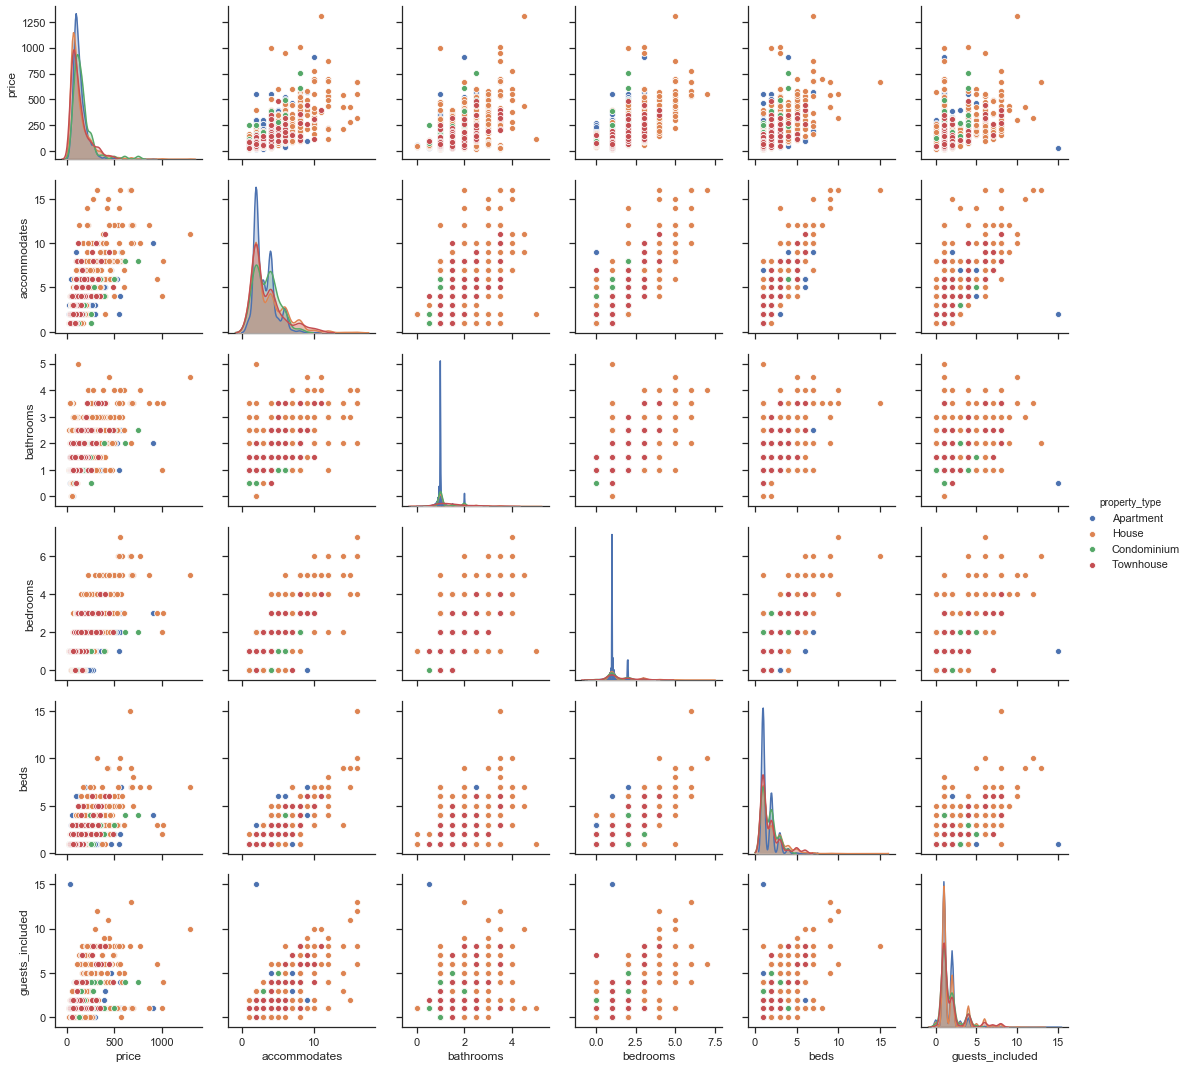

<Figure size 864x720 with 0 Axes>

In [28]:
filtered_listings = listings[listings['property_type'].isin(['House', 'Apartment', 'Condominium', 'Townhouse'])].copy()

g = sns.pairplot(filtered_listings[['price', 'accommodates', 'bathrooms',
                           'bedrooms', 'beds', 'guests_included', 'property_type']], hue='property_type')
sns.despine()
plt.figure(figsize=(12,10))
plt.show()/

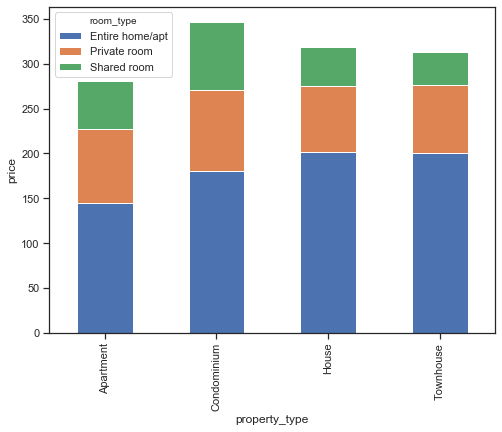

In [31]:
df = filtered_listings.groupby(['property_type', 'room_type'])['price'].mean().unstack()
df.plot.bar(stacked=True, figsize=(8,6))
plt.ylabel('price')
plt.show()

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


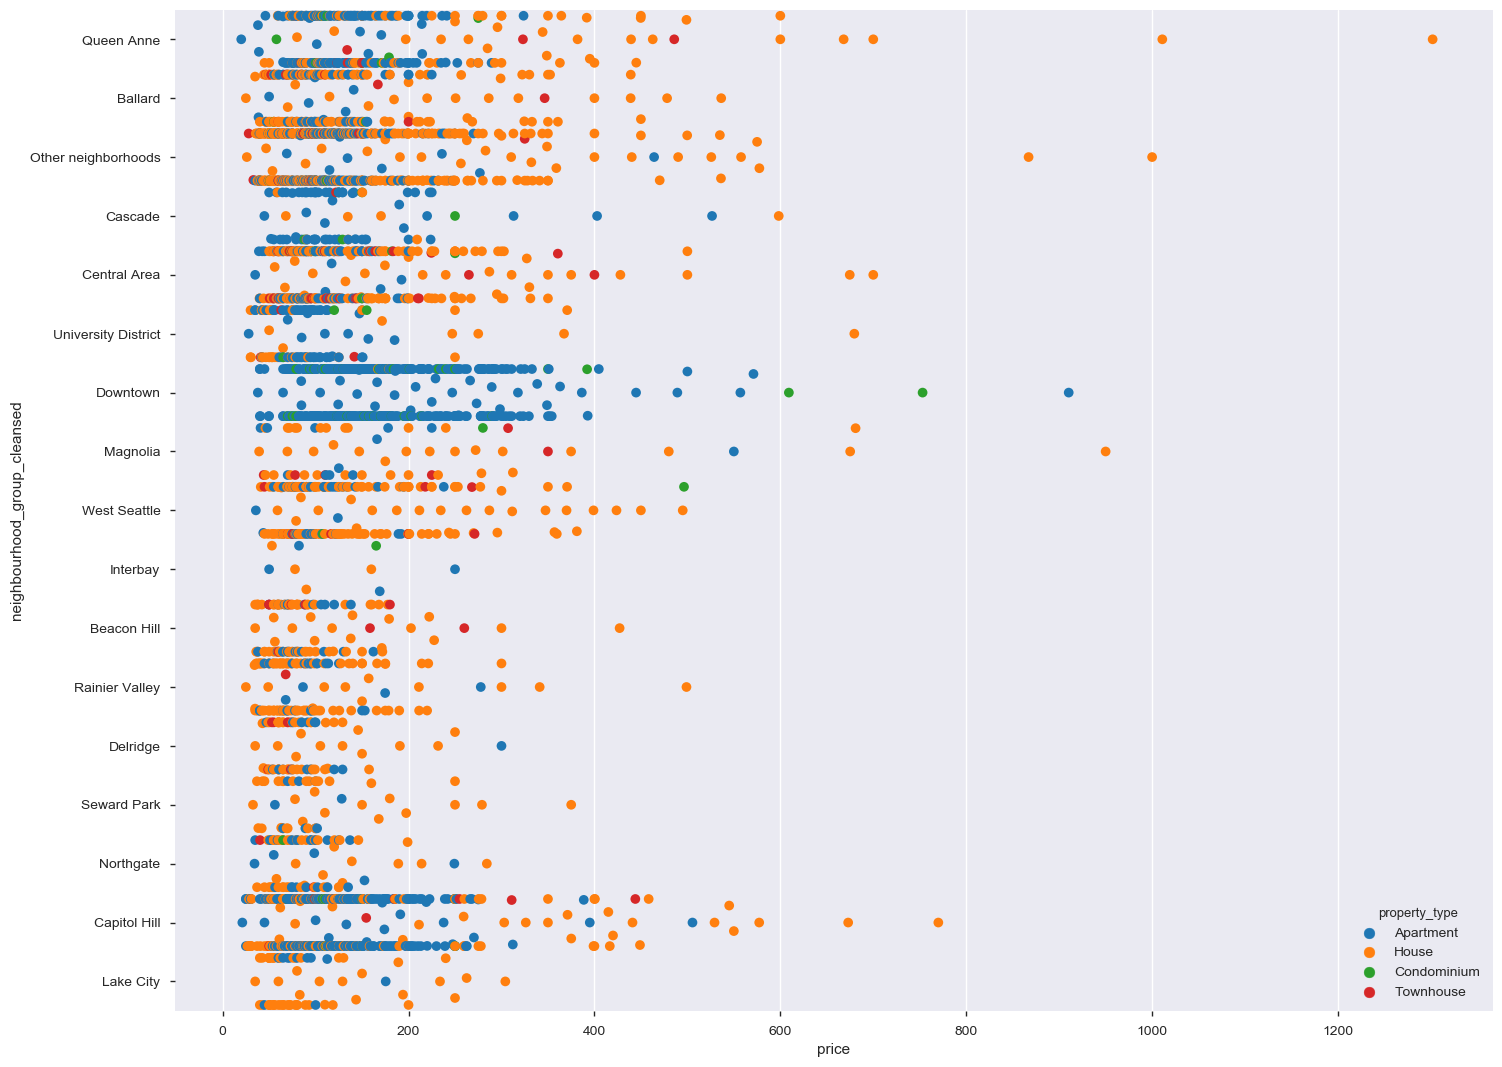

In [23]:
g = sns.swarmplot(y='neighbourhood_group_cleansed',
                 x='price',
                  hue='property_type',
                 data=filtered_listings,
                 size=7)
sns.despine()
g.figure.set_size_inches(17,13)
plt.show()

#### Visualize property price variation in relation to location


c:\code\Udacity\airbnb\functions.py:83: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  llcrnrlon=lon_0-0.05, urcrnrlon=lon_1+0.05)
c:\code\Udacity\airbnb\functions.py:87: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1)
c:\code\Udacity\airbnb\functions.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcounties(color='red', linewidth=1)


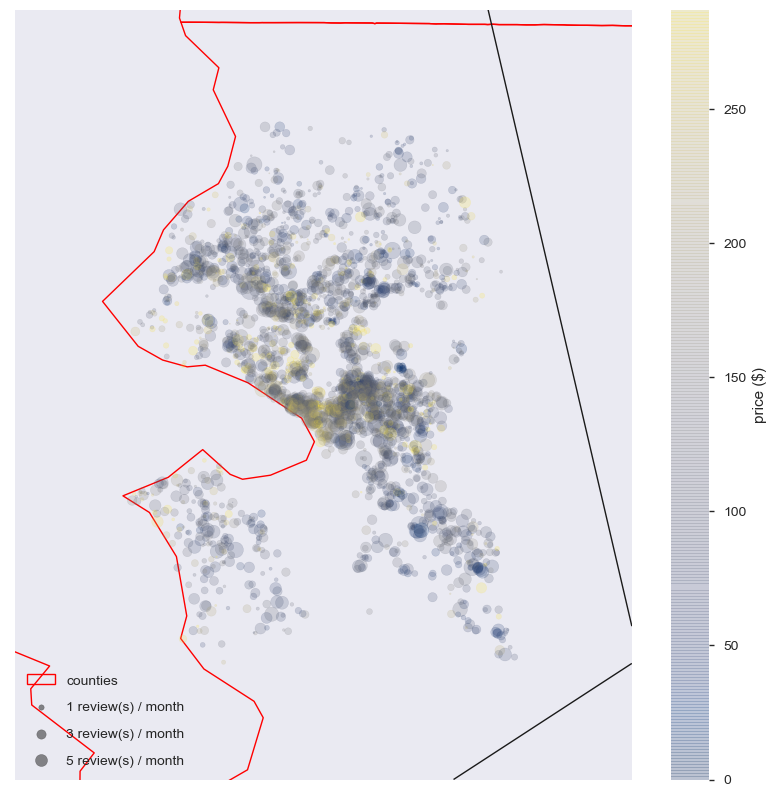

In [24]:
df = listings[['latitude', 'longitude', 'price', 'reviews_per_month']].copy()

#clean df 
df.dropna(axis=0, inplace=True)

latitudes = df.latitude
longitudes = df.longitude
price_distribution = df.price
activity_distribution = df.reviews_per_month

plot_geographical(latitudes, longitudes, price_distribution, activity_distribution)

#### Prepare data for machine learning pipelines


In [25]:
listings_ml = listings.dropna(subset=['price'], axis=0)

X = listings_ml.drop('price', axis=1)
y = listings_ml['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

upper_limit = y_train.quantile(0.99)
lower_limit = y_train.quantile(0.01)

is_over_limit = y_train > upper_limit
is_under_limit = y_train < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

In [34]:
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy', 'host_identity_verified']

cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='most_frequent')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)


X_train_prepared = ct.fit_transform(X_train)
X_test_prepared = ct.transform(X_test)

lin_reg = LinearRegression()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()

cv_scores = []
fit_score = []
for model in (lin_reg, svm_reg, rnd_reg):
    model.fit(X_train_prepared, y_train)
    cv_score = cross_val_score(model, X_train_prepared, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_scores.append(np.sqrt(-cv_score.mean()))
    fit_score.append(model.score(X_train_prepared, y_train))
    
print('linear model - cv: ', cv_scores[0], ' fit: ', fit_score[0] )
print('support vector machine - cv: ', cv_scores[1], ' fit: ', fit_score[1])
print('random forrest regressor - cv: ', cv_scores[2], ' fit: ', fit_score[2])

C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\samee\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\same

linear model - cv:  743566149751.5961  fit:  0.7006898249503604
support vector machine - cv:  68.94550187787068  fit:  0.45261745387410973
random forrest regressor - cv:  48.97490762221058  fit:  0.944823514138305


In [35]:
param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.1, 0.15, 0.20, 0.25], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

grid_search_cv = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_cv.fit(X_train_prepared, y_train)
bst_estm = grid_search_cv.best_estimator_
y_pred = bst_estm.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

59.490443227014886

In [47]:
features = np.concatenate((ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names(),num_cols))
feature_importances = bst_estm.feature_importances_
importances = pd.DataFrame({'features':features, 'importances':feature_importances}).sort_values('importances', ascending=False).reset_index(drop=True).head(n=15)
importances.sample(15)

,features,importances
7,longitude,0.042354
12,x4_Downtown,0.018067
4,x6_Entire home/apt,0.055724
11,number_of_reviews,0.026185
1,accommodates,0.149313
13,x8_strict,0.014055
9,x6_Private room,0.036556
8,availability_365,0.042042
10,guests_included,0.035540
6,reviews_per_month,0.042705


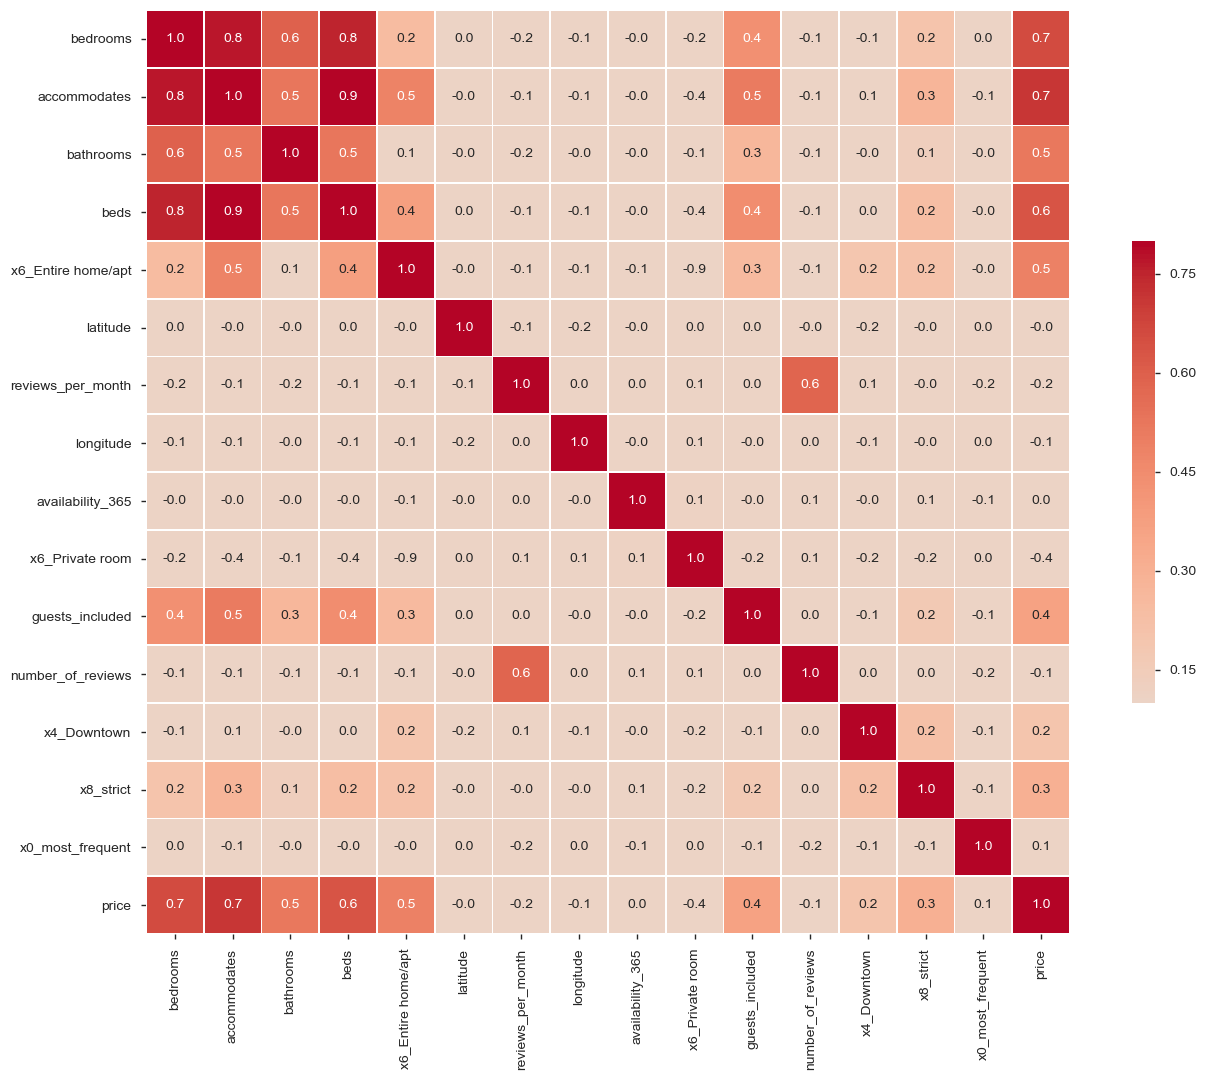

In [48]:
df = pd.DataFrame(X_train_prepared, columns=features)
df = df[importances.features[:15]]
df['price'] = y_train.values

corr = df.corr()

g = sns.heatmap(corr, vmin=0.1, vmax=0.8, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(16,12)

plt.show()

In [45]:
y_train.values

array([ 61.76404494, 130.        ,  71.91620112, ..., 107.54794521,
       107.16292135, 243.93617021])